# tdsm encoder
Here provides the interface of interacting with function in `util` to perform the training & sampling of generative model. 

## import model

In [1]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import util.dataset_structure, util.display, util.model
import tqdm

## Parameter setting

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
padding_value = -20

dataset = "toy_model"
dataset_store_path = "/eos/user/t/tihsu/database/ML_hackthon/toy_model"
transform = None
transform_y = None
mask = True

### Training parameter

In [7]:
batch_size = 150
lr = 0.0001
n_epochs = 500
workingdir = "./"
batch_size = 150
train_ratio = 0.9

sigma = 25.0
vesde = util.dataset_structure.VESDE(device=device)
new_marginal_prob_std_fn = functools.partial(vesde.marginal_prob)
new_diffusion_coeff_fn   = functools.partial(vesde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

files_list_ = []
for filename in os.listdir('samples'):
    if fnmatch.fnmatch(filename, '*' + dataset + '*.pt'):
        files_list_.append(os.path.join('samples', filename))
print(files_list_)

n_features = 4
embed_dim = 64
hidden_dim = 128
n_transformer = 6
n_head  = 4
dropout = 0
model = util.model.Gen(n_features, embed_dim, hidden_dim, n_transformer, n_head, dropout, marginal_prob_std=new_marginal_prob_std_fn)
print('model: ', model)

if mask:
    mask_label = 'mask'
else:
    mask_label = 'no_mask'
    
label = f'embed{embed_dim}_hid{hidden_dim}_{n_transformer}trans_{n_head}head_dropout{dropout}_{mask_label}'
print('label:', label)

torch version:  1.11.0a0+gitbc2c6ed
Running on device:  cuda
Cuda used to build pyTorch:  11.7
Current device:  0
Cuda arch list:  ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']
Working directory:  ./
['samples/toy_model.pt']
Initial GaussianFourierProjection W weights: Parameter containing:
tensor([ 10.5974,  52.9606,   7.4654,  14.0131, -41.1310, -65.1886,  -6.4550,
         -9.1337,  19.5923,  12.9296,   4.2607,   7.2818,   0.2795,  20.8819,
        -54.9812,  -5.9966,  29.8464, -12.1570,  27.7259, -36.8879,  24.4611,
        -55.1731, -47.0885,  56.2803,  -6.9121,  47.7538,  43.1906,  10.3425,
        -18.3792,   4.6198, -35.4150, -24.0527])
Initial Dense weights: Parameter containing:
tensor([[ 0.0519, -0.1237, -0.0771,  0.0173, -0.0072, -0.0218, -0.0492, -0.0039,
         -0.0559, -0.0079,  0.0832,  0.0043, -0.0598, -0.0597,  0.0796, -0.0043,
         -0.0670, -0.0806,  0.0970,  0.0503,  0.0216, -0.0452, -0.0105,  0.0512,
         -0.0582,  0.0156, -0.0924, 

## Pad data (Optional)

In [8]:
files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, '*' + dataset + '*.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
        
tqdm_file = tqdm.notebook.trange(len(files_list_))
os.system("mkdir -p samples")
for index in tqdm_file:
    file_name = files_list_[index]
    data = util.dataset_structure.cloud_dataset(file_name, device=device)
    data.padding()
    data.save(os.path.join("samples", (file_name.split('/')[-1]).replace('no_pedding','padding')))

  0%|          | 0/1 [00:00<?, ?it/s]

/eos/home-i00/t/tihsu/SWAN_projects/ML_hackathon/tdsm_encoder/util/dataset_structure.py:10: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



## Plot data distribution (Optional)

/eos/home-i00/t/tihsu/SWAN_projects/ML_hackathon/tdsm_encoder/util/dataset_structure.py:10: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



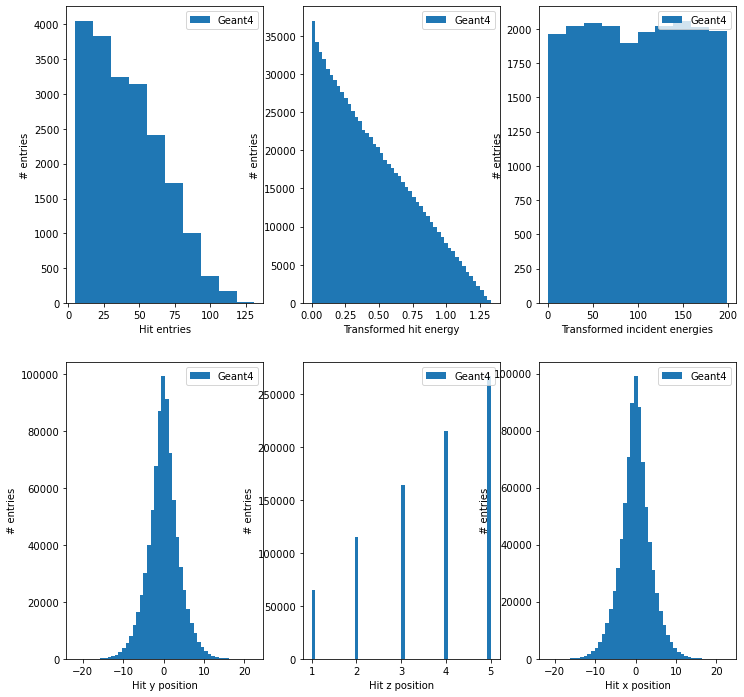

In [8]:
plot_file_name = "samples/toy_model.pt"
custom_data = util.dataset_structure.cloud_dataset(plot_file_name,device=device, transform=transform, transform_y=transform_y)
point_clouds_loader = DataLoader(custom_data, batch_size=150, shuffle=False)
fig = util.display.plot_distribution(point_clouds_loader, label="Geant4")
fig.show()

## Training

### Start to train!!

Output directory:  training_result/embed64_hid128_6trans_4head_dropout0_mask/


  0%|          | 0/500 [00:00<?, ?it/s]

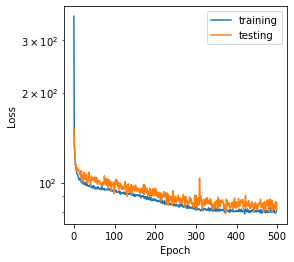

Gen(
  (embed): Linear(in_features=4, out_features=64, bias=True)
  (embed_t): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (dense1): Dense(
    (dense): Linear(in_features=64, out_features=1, bias=True)
  )
  (encoder): ModuleList(
    (0): Block(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (dropout): Dropout(p=0, inplace=False)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (fc1_cls): Linear(in_features=64, out_features=128, bias=True)
      (fc2_cls): Linear(in_features=128, out_features=64, bias=True)
      (act): GELU()
      (act_dropout): Dropout(p=0, inplace=False)
    )
    (1): Block(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
 

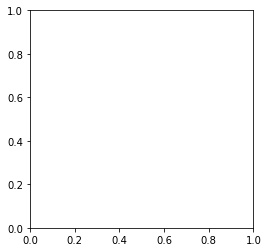

In [9]:
util.model.training(batch_size = batch_size,
                    lr = lr,
                    n_epochs = n_epochs,
                    model = model,
                    new_marginal_prob_std_fn = new_marginal_prob_std_fn,
                    device = device,
                    jupyternotebook = True,
                    files_list = files_list_,
                    train_ratio = train_ratio,
                    mask=mask, padding_value=padding_value,
                    label=label,
                    transform = transform,
                    transform_y = transform_y)

## Sampling 

In [10]:
hits_energies = torch.rand(20000)*200
sample, in_energies, nhits = util.model.generate_sample(model=model,
                                                        marginal_prob_std=new_marginal_prob_std_fn, 
                                                        diffusion_coeff=new_diffusion_coeff_fn,
                                                        sample_batch_size=10000,
                                                        n_bin=200,
                                                        load_name = "training_result/"+label+"/ckpt_tmp_499.pth",
                                                        device=device,
                                                        in_energies=hits_energies,
                                                        sampled_file_list=["samples/toy_model.pt"],
                                                        mask=mask, 
                                                        jupyternotebook=True,
                                                        label = label,
                                                        transform = transform,
                                                        transform_y = transform_y,
                                                        padding_value=0)

output_directory: sampling/embed64_hid128_6trans_4head_dropout0_mask
Progress: 1/2

  0%|          | 0/100 [00:00<?, ?it/s]

Progress: 2/2

  0%|          | 0/100 [00:00<?, ?it/s]

## Draw Generative Distribution

In [ ]:
plot_file_name = "sampling/"+label+"/sample.pt"
custom_data = util.dataset_structure.cloud_dataset(plot_file_name,device=device, transform = transform, transform_y=transform_y)
custom_data.padding()
point_clouds_loader = DataLoader(custom_data, batch_size=150, shuffle=False)
fig = util.display.plot_distribution(point_clouds_loader, label="Gen")
fig.show()